In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import sigpy
import itertools

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (6, 4)

import subtle.subtle_io as suio

from keras.layers import Input, Conv3D, Activation, ReLU
import keras.models
from keras.optimizers import Adam
from subtle.data_loaders import BlockLoader


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)
    plt.show()

    
def get_patches(img_vol, block_size=64, strides=64):
    patches = sigpy.block.array_to_blocks(img_vol, blk_shape=[block_size]*3, blk_strides=[strides]*3)
    print(patches.shape)
    n_patches = patches.shape[0] * patches.shape[1] * patches.shape[2]
    patches = np.reshape(patches, (n_patches, block_size, block_size, block_size))
    return patches

def filter_patches(patches, pixel_percent=0.1, block_size=64):
    filt_patches = []
    get_nz = lambda plist: np.sum([len(np.nonzero(sl)[0]) for sl in plist])
    sel_idx = []
    
    for i, patch in enumerate(patches):
        percent = get_nz(patch.reshape((block_size, block_size**2))) / (block_size ** 3)
        if percent >= pixel_percent:
            filt_patches.append(patch)
            sel_idx.append(i)
    return np.array(filt_patches), np.array(sel_idx)

def conv_block(input, filters, strides=2):
    d_out = Conv3D(filters=filters, kernel_size=3, strides=strides, padding='same')(input)
    d_out = ReLU()(d_out)
    return d_out

def get_num_blocks(data_file, block_size=128, strides=32):
    ims = suio.load_file(data_file, file_type='h5')
    ims_zero, _, _ = ims.transpose(1, 0, 2, 3)
    
    bsize = [block_size]*3
    bstrides = [strides]*3
    num_blocks = [(i - b + s) // s for i, b, s in zip(ims_zero.shape, bsize, bstrides)]
    return np.cumprod(num_blocks)[-1]

Using TensorFlow backend.


In [ ]:
study_data = suio.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO1.h5')

ims_zero, ims_low, ims_full = study_data.transpose(1, 0, 2, 3)

bsize = 64
stride = 16
ns, nx, ny = ims_zero.shape

x_blocks = (nx - bsize + stride) // stride

get_sweeps = lambda N: [(b*stride, (b*stride) + bsize) for b in range((N - bsize + stride) // stride)]

s_sweeps = get_sweeps(ns)
x_sweeps = get_sweeps(nx)
y_sweeps = get_sweeps(ny)

print(s_sweeps)
pdt = list(itertools.product(s_sweeps, x_sweeps, y_sweeps))

blocks_zero = []
blocks_low = []
blocks_full = []

for idxs in pdt:
    ((ss, se), (xs, xe), (ys, ye)) = idxs
    blocks_zero.append(ims_zero[ss:se, xs:xe, ys:ye])
    blocks_low.append(ims_low[ss:se, xs:xe, ys:ye])
    blocks_full.append(ims_full[ss:se, xs:xe, ys:ye])

blocks_zero = np.array(blocks_zero)
blocks_low = np.array(blocks_low)
blocks_full = np.array(blocks_full)

In [ ]:
show_img(blocks_zero[200, :, :, 32])
show_img(blocks_low[200, :, :, 32])
show_img(blocks_full[200, :, :, 32])

In [ ]:
ims = study_data.transpose(1, 0, 2, 3)

blocks = sigpy.block.array_to_blocks(ims, blk_shape=[1, 64, 64, 64], blk_strides=[1, 64, 64, 64])

block_zero, block_low, block_full = blocks

breshape = blocks.reshape(3, 27, 64, 64, 64)
print(breshape.shape)
# block_zero = block_zero.reshape(27, 64, 64, 64)
# block_low = block_low.reshape(27, 64, 64, 64)
# block_full = block_full.reshape(27, 64, 64, 64)

show_img(breshape[0, 15, 32])
show_img(breshape[0, 15, 32])
show_img(breshape[0, 15, 32])

In [ ]:
input = Input(shape=(64, 64, 64, 2))

d_out = conv_block(input, 32)
d_out = conv_block(d_out, 64)
d_out = conv_block(d_out, 128)

output = conv_block(d_out, 1, strides=1)
output = Activation('sigmoid')(output)

model = keras.models.Model(inputs=input, outputs=output)
model.summary()

model.compile(loss='mse', optimizer=Adam())

In [ ]:
inp_patches = np.array([zero_patches, low_patches]).transpose((1, 2, 3, 4, 0))
out_patches = np.ones((inp_patches.shape[0], 8, 8, 8, 1))

In [2]:
data_dir = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data'
case_nums = suio.get_experiment_data('stanford_sri', dataset='train', dirpath_exp='../experiments')
data_list = ['{}/{}.h5'.format(data_dir, cnum) for cnum in case_nums]

block_loader = BlockLoader(
    data_list=data_list,
    batch_size=8,
    shuffle=True,
    block_size=128,
    strides=64
)

  0%|          | 0/18 [00:00<?, ?it/s]

Building list of 3D blocks...


100%|██████████| 18/18 [00:10<00:00,  2.04it/s]


In [3]:
X, Y, weights = block_loader.__getitem__(15)

[ True False  True False False  True  True  True]


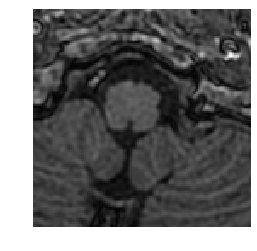

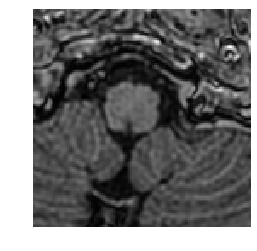

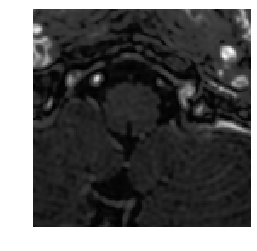

In [4]:
print(weights)
show_img(X[0, 0, 64])
show_img(X[0, 1, 64])
show_img(Y[0, 64])